# HW2: Bias in data

## 1. Getting the article and population data

**Article data:**The wikipedia dataset can be found on [Figshare](https://figshare.com/articles/Untitled_Item/5513449).

**Population data:**The population data is on the [Population Research Bureau website](http://www.prb.org/DataFinder/Topic/Rankings.aspx?ind=14). 

In [1]:
import csv

article = []
with open('../raw_data/page_data.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        article.append(row)
        
article[:5]

[['page', 'country', 'rev_id'],
 ['Template:ZambiaProvincialMinisters', 'Zambia', '235107991'],
 ['Bir I of Kanem', 'Chad', '355319463'],
 ['Template:Zimbabwe-politician-stub', 'Zimbabwe', '391862046'],
 ['Template:Uganda-politician-stub', 'Uganda', '391862070']]

In [2]:

population = []
with open('../raw_data/Population Mid-2015.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        population.append(row)
        
population[:5]

[['Population Mid-2015'],
 [],
 ['Location', 'Location Type', 'TimeFrame', 'Data Type', 'Data', 'Footnotes'],
 ['Afghanistan', 'Country', 'Mid-2015', 'Number', '32,247,000', ''],
 ['Albania', 'Country', 'Mid-2015', 'Number', '2,892,000', '']]

## 2. Getting article quality predictions

In [3]:
import requests
import json

headers = {'User-Agent' : 'https://github.com/wangbeiqi199159', 'From' : 'beiqiw@uw.edu'}

def get_ores_data(revision_ids, headers):
    
    # Define the endpoint
    endpoint = 'https://ores.wikimedia.org/v3/scores/{project}/?models={model}&revids={revids}'
    
    # Specify the parameters - smushing all the revision IDs together separated by | marks.
    # Yes, 'smush' is a technical term, trust me I'm a scientist.
    # What do you mean "but people trusting scientists regularly goes horribly wrong" who taught you tha- oh.  
    params = {'project' : 'enwiki',
              'model'   : 'wp10',
              'revids'  : '|'.join(str(x) for x in revision_ids)
              }
    api_call = requests.get(endpoint.format(**params))
    response = api_call.json()
    return response


In [4]:
ids = []
for i in range(1, len(article)):
    ids.append(int(article[i][2]))
    
len(ids)

47197

In [5]:
quality = []
start = 0

while start < len(ids):
    end = min(start + 100, len(ids))
    score = get_ores_data(ids[start : end], headers)
    for rev_id in score['enwiki']['scores']:
        if 'score' in score['enwiki']['scores'][rev_id]['wp10']:
            quality.append(score['enwiki']['scores'][rev_id]['wp10']['score']['prediction'])
        else:
            quality.append(None)
    start = start + 100
    
len(quality)

47197

## 3. Combining the datasets

In [6]:
import pandas as pd
import numpy as np

In [7]:
article_name = []
for i in range(1, len(article)):
    article_name.append(article[i][0])
    
country = []
for i in range(1, len(article)):
    country.append(article[i][1])

article_df = pd.DataFrame({'article_name' : article_name,
                          'country' : country,
                          'revision_id' : ids,
                          'article_quality' : quality})

article_df[:5]

,article_name,article_quality,country,revision_id
0,Template:ZambiaProvincialMinisters,Stub,Zambia,235107991
1,Bir I of Kanem,Stub,Chad,355319463
2,Template:Zimbabwe-politician-stub,Stub,Zimbabwe,391862046
3,Template:Uganda-politician-stub,Stub,Uganda,391862070
4,Template:Namibia-politician-stub,Stub,Namibia,391862409


In [8]:
location = []
for i in range(3, len(population) - 1):
    location.append(population[i][0])
    
data = []
for i in range(3, len(population) - 1):
    data.append(int(population[i][4].replace(',', '')))

population_df = pd.DataFrame({'country' : location,
                          'population' : data})

population_df[:5]

,country,population
0,Afghanistan,32247000
1,Albania,2892000
2,Algeria,39948000
3,Andorra,78000
4,Angola,25000000


In [9]:
df = pd.merge(article_df, population_df, on='country', how='inner')
df[:5]

,article_name,article_quality,country,revision_id,population
0,Template:ZambiaProvincialMinisters,Stub,Zambia,235107991,15473900
1,Gladys Lundwe,Stub,Zambia,757566606,15473900
2,Mwamba Luchembe,Stub,Zambia,764848643,15473900
3,Thandiwe Banda,Start,Zambia,768166426,15473900
4,Sylvester Chisembele,C,Zambia,776082926,15473900


In [10]:
df.to_csv('../cleaned_data/' + 'cleaned_data.csv', sep=',')

## 4. Analysis

### (1) Articles per population (%)

In [11]:
articles_counts = df.groupby(['country'])['article_name'].count()
populations = df.groupby(['country'])['population'].mean()
articles_per_population = articles_counts / populations * 100
articles_per_population = articles_per_population.round(6)
articles_per_population[: 10]

country
Afghanistan            0.001014
Albania                0.015906
Algeria                0.000298
Andorra                0.043590
Angola                 0.000440
Antigua and Barbuda    0.027778
Argentina              0.001169
Armenia                0.006596
Australia              0.006556
Austria                0.003946
dtype: float64

### (2) High-quality articles rate (%)

In [12]:
high_quality = df.loc[(df['article_quality'] == 'FA') | (df['article_quality'] == 'GA')]
high_quality_counts = high_quality.groupby(['country'])['article_name'].count()
high_quality_rate = high_quality_counts / populations * 100
high_quality_rate = high_quality_rate.replace(np.nan, 0).round(6)
high_quality_rate[: 10]

country
Afghanistan            0.000059
Albania                0.000173
Algeria                0.000008
Andorra                0.000000
Angola                 0.000008
Antigua and Barbuda    0.000000
Argentina              0.000038
Armenia                0.000199
Australia              0.000184
Austria                0.000035
dtype: float64

## 5. Visualization

### (1) 10 highest-ranked countries in terms of number of politician articles as a proportion of country population

In [13]:
import matplotlib.pyplot as plt

In [14]:
highest_article_per_country = articles_per_population.sort_values(ascending = False)[0 : 10]
highest_article_per_country

country
Nauru                             0.488029
Tuvalu                            0.466102
San Marino                        0.248485
Monaco                            0.105020
Liechtenstein                     0.077189
Marshall Islands                  0.067273
Iceland                           0.062268
Tonga                             0.060987
Andorra                           0.043590
Federated States of Micronesia    0.036893
dtype: float64

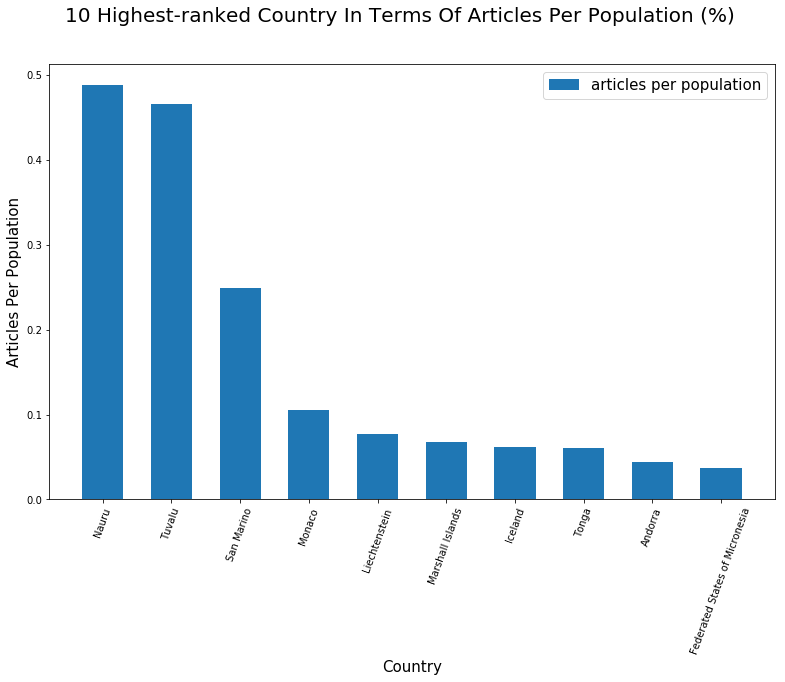

In [15]:
lables = highest_article_per_country.index
values = highest_article_per_country.values
y_pos = np.arange(len(lables))

fig, ax = plt.subplots()

ax.bar(y_pos, values, width = 0.6, label = 'articles per population' )

fig.set_size_inches(13, 8)
plt.xticks(y_pos, lables, rotation=70)
plt.legend(prop={'size': 15})
fig.suptitle('10 Highest-ranked Country In Terms Of Articles Per Population (%)', fontsize=20)
ax.set_xlabel('Country')
ax.set_ylabel('Articles Per Population')
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)

plt.show()


### (2) 10 lowest-ranked countries in terms of number of politician articles as a proportion of country population

In [16]:
lowest_article_per_country = articles_per_population.sort_values()[0 : 10]
lowest_article_per_country

country
India                  0.000075
China                  0.000083
Indonesia              0.000084
Uzbekistan             0.000093
Ethiopia               0.000107
Korea, North           0.000156
Zambia                 0.000168
Thailand               0.000172
Congo, Dem. Rep. of    0.000194
Bangladesh             0.000202
dtype: float64

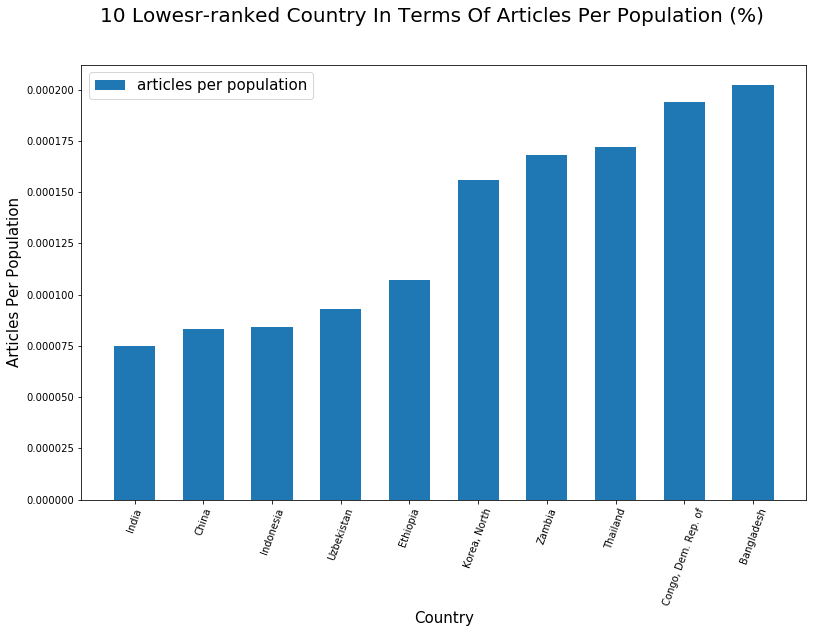

In [17]:
lables = lowest_article_per_country.index
values = lowest_article_per_country.values
y_pos = np.arange(len(lables))

fig, ax = plt.subplots()

ax.bar(y_pos, values, width = 0.6, label = 'articles per population' )

fig.set_size_inches(13, 8)
plt.xticks(y_pos, lables, rotation=70)
plt.legend(prop={'size': 15})
fig.suptitle('10 Lowesr-ranked Country In Terms Of Articles Per Population (%)', fontsize=20)
ax.set_xlabel('Country')
ax.set_ylabel('Articles Per Population')
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)

plt.show()

### (3) 10 highest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country


In [18]:
highest_high_quality_rate = high_quality_rate.sort_values(ascending = False)[0 : 10]
highest_high_quality_rate

country
Tuvalu                   0.008475
Vanuatu                  0.001081
Iceland                  0.000907
Grenada                  0.000901
Ireland                  0.000670
Maldives                 0.000576
Bhutan                   0.000396
Gabon                    0.000343
Montenegro               0.000321
Palestinian Territory    0.000268
dtype: float64

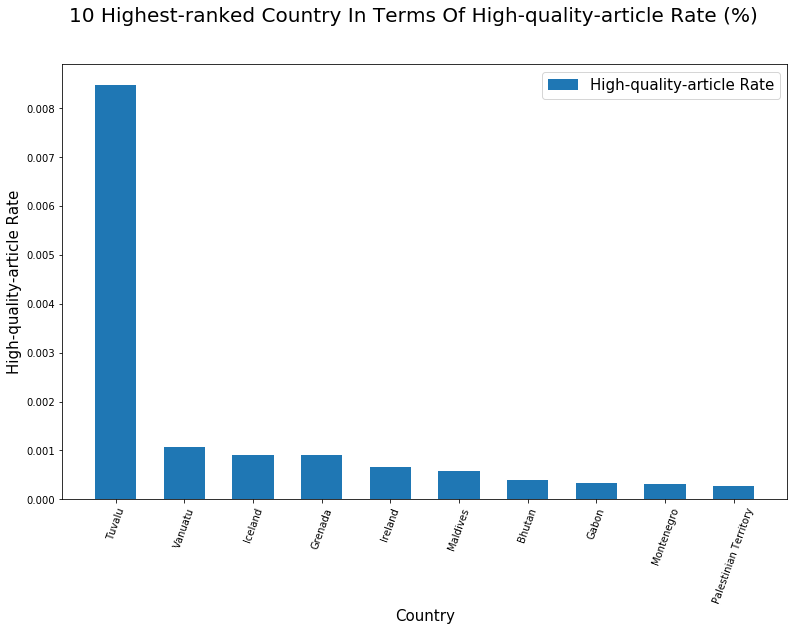

In [19]:
lables = highest_high_quality_rate.index
values = highest_high_quality_rate.values
y_pos = np.arange(len(lables))

fig, ax = plt.subplots()

ax.bar(y_pos, values, width = 0.6, label = 'High-quality-article Rate' )

fig.set_size_inches(13, 8)
plt.xticks(y_pos, lables, rotation=70)
plt.legend(prop={'size': 15})
fig.suptitle('10 Highest-ranked Country In Terms Of High-quality-article Rate (%)', fontsize=20)
ax.set_xlabel('Country')
ax.set_ylabel('High-quality-article Rate')
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)

plt.show()

### (4) 10 lowest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country

In [20]:
lowest_high_quality_rate = high_quality_rate.sort_values()[0 : 10]
lowest_high_quality_rate

country
Guyana             0.0
Mozambique         0.0
Eritrea            0.0
Seychelles         0.0
Burundi            0.0
Monaco             0.0
Kazakhstan         0.0
Kiribati           0.0
Cape Verde         0.0
Solomon Islands    0.0
dtype: float64

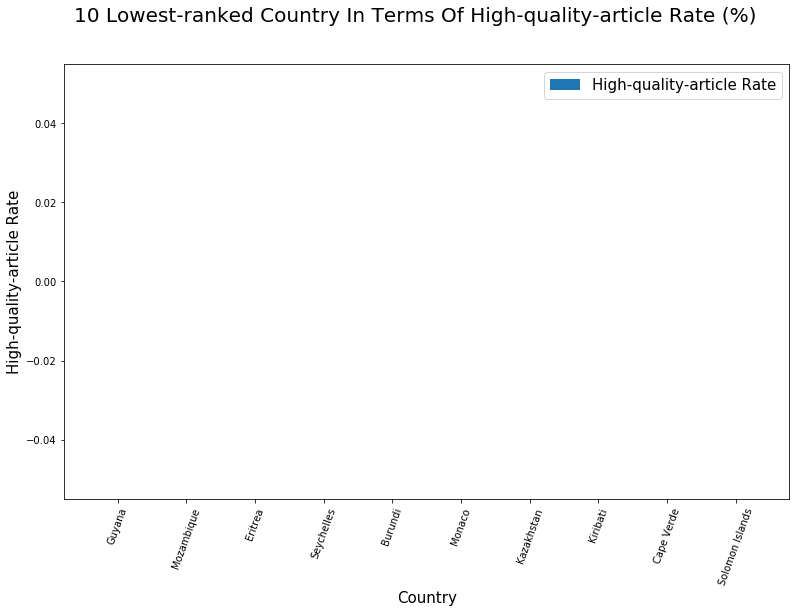

In [21]:
lables = lowest_high_quality_rate.index
values = lowest_high_quality_rate.values
y_pos = np.arange(len(lables))

fig, ax = plt.subplots()

ax.bar(y_pos, values, width = 0.6, label = 'High-quality-article Rate' )

fig.set_size_inches(13, 8)
plt.xticks(y_pos, lables, rotation=70)
plt.legend(prop={'size': 15})
fig.suptitle('10 Lowest-ranked Country In Terms Of High-quality-article Rate (%)', fontsize=20)
ax.set_xlabel('Country')
ax.set_ylabel('High-quality-article Rate')
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)

plt.show()